# colormaps

This notebook shows some images (synthetic and real topography) using different color palettes, just to reinforce the point that others have made (see references below): that we need to choose a "good" colormap (i.e. a perceptually uniform colormap) if we want to communicate truthfully the results and not artificially emphasize certain features.

## note

To run the code below, in addition to the usual libraries (numpy, matplotlib) you also need [xarray](http://xarray.pydata.org/en/stable/) and [colorcet](https://colorcet.holoviz.org/) to have a few more "good" colormaps to choose from.

## references

* Crameri, Fabio, Grace E. Shephard, and Philip J. Heron. “The Misuse of Colour in Science Communication.” Nature Communications 11, no. 1 (December 2020): 5444. https://doi.org/10.1038/s41467-020-19160-7.
* Froner, B., S.J. Purves, J. Lowell, and J. Henderson. “Perception of Visual Information: The Role of Colour in Seismic Interpretation.” First Break 31, no. 4 (April 1, 2013). https://doi.org/10.3997/1365-2397.2013010.
* ["Good Colour Maps: How to Design Them"](https://arxiv.org/pdf/1509.03700v1.pdf), by Peter Kovesi
* Companion website to the above article: <http://peterkovesi.com/projects/colourmaps/index.html>
* Colorcet is a python package collecting all of Peter Kovesi's maps: https://colorcet.holoviz.org/
* How bad is your colomap?, blog post by Jake Van den plas: <https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/>
* Niccoli, Matteo. “Geophysical Tutorial: How to Evaluate and Compare Color Maps.” The Leading Edge 33, no. 8 (August 2014): 910–12. https://doi.org/10.1190/tle33080910.1.
* Color palette goodies from Matteo Niccoli: <https://mycarta.wordpress.com/color-palettes/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import colorcet as cc
import xarray as xr

import requests
import io

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

The following cell load a few more maps from a compressed numpy file and register them in Matplotlib so they become available for use, and can be selected by simply specifying their names, e.g. `landmark`, the same way you would specify one of the Matplotlib colormaps.

In [2]:
remote_file = 'https://github.com/aadm/geophysical_notes/raw/master/aadm_colormaps.npz'
response = requests.get(remote_file)
cmaps = np.load(io.BytesIO(response.content))

cmaps_names = [
    'matteo_cube',
    'matteo_cubeYF',
    'matteo_linear',
    'matteo_sawtooth',
    'yrwbc',
    'sharp',
    'seis',
    'petrel',
    'rainbowcet',
    'landmark']

for jj in cmaps_names:
    tmp = ListedColormap(cmaps[jj], name=jj)
    tmp_r = ListedColormap(np.flipud(cmaps[jj]), name=jj+'_r')
    mpl.colormaps.register(name=jj, cmap=tmp)
    mpl.colormaps.register(name=jj+'_r', cmap=tmp_r)
    #cm.register_cmap(name=jj, cmap=tmp)
    #cm.register_cmap(name=jj+'_r', cmap=tmp_r)

The idea is to compare a few of the classic (and awful) colormaps historically present in Matplotlib (e.g., `jet` and `rainbow`), some of the new, perceptually uniform maps (e.g., `viridis`, `cividis`, `magma`) plus the custom ones loaded above.

More specifically I have added the following maps:

* `matteo_cube`, `matteo_cubeYF`, `matteo_linear`, `matteo_sawtooth`: see [here](https://mycarta.wordpress.com/color-palettes/)
* `seis`, `yrwbc`, `sharp`, `petrel`: these are divergent colormaps, the first is the standard red to blue colormap historically used for seismic data (similar to `seismic`, `RdBu`, `bwr` in Matplotlib); `yrwbc` is a variation of the first where extreme negatives and positives are highlighted in yellow and cyan (once again, an historically accepted colormap used to analyze subtle amplitude variations), while the last two replicate the default colormaps used for seismic data in two commercial packages I have used in the past.
* `landmark`: this is the ugliest colormap of all times, but it is a default for displaying horizons in Landmark's Decision Space so I had to put it in just as an example of how bad this is, how much artifacts it creates etc
* `rainbowcet` is a copy of Colorcet/Kovesi rainbow map (see also [here](https://colorcet.holoviz.org/user_guide/index.html))

The cell block below defines a few functions (copied and modified from matplotlib docs, stackoverflow, [Matteo Niccoli's blog](https://mycarta.wordpress.com/2014/11/12/visualizing-colormap-artifacts/)):

In [3]:
def plot_cmaps(cmaps):
    '''
    plot colormaps

    source:
    https://matplotlib.org/stable/gallery/color/colormap_reference.html
    '''
    tmp = np.linspace(0, 1, 256)
    gradient = np.vstack((tmp, tmp))
    nmaps = len(cmaps)

    figh = 0.5 + 0.15 + (nmaps + (nmaps-1)*0.1)*0.3
    f, axs = plt.subplots(nrows=nmaps, figsize=(6.4, figh))
    f.subplots_adjust(top=1-.15/figh, bottom=.15/figh, left=0.2, right=0.99)

    for ax, name in zip(axs, cmaps):
        ax.imshow(gradient, aspect='auto', cmap=name)
        ax.text(-2, .5, name, va='center', ha='right')
        ax.set_axis_off()

def rgb2lab(inputColor):
    '''
    Adapted from 
    https://stackoverflow.com/questions/13405956/convert-an-image-rgb-lab-with-python
    '''
    num = 0
    RGB = [0, 0, 0]

    for value in inputColor :
        if value > 0.04045 :
            value = ( ( value + 0.055 ) / 1.055 ) ** 2.4 # 2.4 is gamma correction
        else :
            value = value / 12.92
        RGB[num] = value * 100
        num = num + 1

    XYZ = [0, 0, 0,]
    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )
    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883
    num = 0
    for num, value in enumerate(XYZ):
        if value > 0.008856 :
            value = value ** (1/3)
        else :
            value = ( 7.787 * value ) + ( 16 / 116 )
        XYZ[num] = value
    Lab = [0, 0, 0]
    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )
    Lab [ 0 ] = round( L, 4 )
    Lab [ 1 ] = round( a, 4 )
    Lab [ 2 ] = round( b, 4 )
    return Lab

def plot_cmap_lightness(cmaps, divergent=False):
    '''
    Plot lightness of given colormaps.
    Adapted by aadm from original code on matplotlib docs,
    replacing colorspacious with two alternatives to calculate *L (lightness):

    Source:
    1) https://matplotlib.org/stable/tutorials/colors/colormaps.html
    '''
    x = np.linspace(0.0, 1.0, 256)
    nmaps = len(cmaps)

    f, ax = plt.subplots(figsize=(1.5*nmaps, 3),
                            constrained_layout=True)
    locs = []  # locations for text labels
    for j, cmap in enumerate(cmaps):
        # Get RGB values for colormap and convert the colormap in
        # CAM02-UCS colorspace.  lab[0, :, 0] is the lightness.
        # rgb = cm.get_cmap(cmap)(x)[np.newaxis, :, :3]
        rgb = mpl.colormaps[cmap](x)[np.newaxis, :, :3] # shape (1, 256, 3)

        lab = np.zeros(rgb.shape)
        for i in range(rgb.shape[1]):
            lab[0, i, :] = rgb2lab(rgb[0, i, :])

        y_ = lab[0, :, 0]
        c_ = x
        dc = 2  # cmaps horizontal spacing
        ax.scatter(x+j*dc, y_, c=c_, cmap=cmap, s=300, linewidths=0.0)

        # Store locations for colormap labels
        if divergent:
            locs.append(x[int(x.size/2.)] + j*dc)
        else:
            locs.append(x[-1] + j*dc)

    ax.set_ylim(0.0, 100.0)
    # Set up labels for colormaps
    ax.xaxis.set_ticks_position('top')
    ticker = mpl.ticker.FixedLocator(locs)
    ax.xaxis.set_major_locator(ticker)
    formatter = mpl.ticker.FixedFormatter(cmaps[0:nmaps])
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_tick_params(rotation=50)
    ax.set_ylabel('Lightness $L^*$', fontsize=12)


def add_landmarks(ax, coords, names):
    arrs = dict(arrowstyle='->', color='w',
               connectionstyle='arc3,rad=.3')
    boxs = dict(boxstyle="round", fc="white", ec="none")
    for i, nn in enumerate(names):
        xl, yl = coords[i,1], coords[i,0]
        xt, yt = xl-xl*.05, yl-yl*.005
        ax.plot(xl, yl, 'ow', mfc='none')
        ax.annotate(nn, xy=(xl, yl), xytext=(xt, yt),
                    arrowprops=arrs, bbox=boxs, color='k')


def rainbow_fill_between(ax, x, y, y2=0, cmap='cividis'):
    from matplotlib.colors import Normalize
    normlz = Normalize(vmin=y.min(), vmax=y.max())
    cmap0 = plt.get_cmap(cmap)
    for i in range(x.size - 1):
        xx = [x[i], x[i+1]]
        yy =  [y[i], y[i+1]]
        colr = cmap0(normlz(y[i]))
        ax.fill_between(xx, yy, y2=y2, color=colr)


def make_cmap_model(model=0, nbins=100):
    '''
    make two synthetic models to show the effect
    on colormaps:
    1) mountain and valley
    2) fold
    '''
    # set x, y limits
    x = np.linspace(-3, 3, nbins)
    y = np.linspace(-3, 3, nbins)
    X0, Y0 = np.meshgrid(x, y)

    # make model 0
    Za = np.exp(-(X0+1.5)**2 - (Y0+.5)**2)
    Zb = np.exp(-(X0-.5)**2 - (Y0-.5)**2)
    Z0 = (0.9*Za - 0.6*Zb) * 2

    # make model 1
    Z1 = np.sin(X0 + Y0/4)

    # make xarrays and return them
    model0 = xr.DataArray(Z0, coords=[("y", y), ("x", x)])
    model1 = xr.DataArray(Z1, coords=[("y", y), ("x", x)])
    return model0, model1


def plot_cmap_model(model, y=None, baseline=0, cmap='cividis',
                    color='black', title=None):
    # line properties of selected profile along the horizontal (y=nnn)
    opt = dict(color=color, lw=4, alpha=0.5)

    # do the plot
    f, ax = plt.subplots(nrows=2, figsize=(8, 6),
                         constrained_layout=True,
                         sharex=True)
    model.plot(ax=ax[0], center=False, cmap=cmap)
    if y is not None:
        # extracts z profile at selected y
        line = model.sel(y=y, method='nearest')
        lx, ly = line.x.data, line.data
        ax[0].axhline(y=y, ls='--', **opt)
        line.plot(ax=ax[1], **opt)
        rainbow_fill_between(ax[1], lx, ly, baseline, cmap=cmap)
        ax[1].set_ylim(baseline, ly.max())
    ax[1].set_title(None)
    if title is None:
        f.suptitle('Colormap: '+cmap, fontsize='x-large')
    return ax


def plot_cmap_topo(topo, y=None, baseline=0, cmap='cividis',
                   color='black', title=None):
    # line properties of selected profile along the horizontal (y=nnn)
    opt = dict(color=color, lw=4, alpha=0.5)

    # do the plot
    f, ax = plt.subplots(nrows=2, figsize=(8, 6),
                         constrained_layout=True,
                         sharex=True)
    topo.z.plot(ax=ax[0], center=False, cmap=cmap)
    if y is not None:
        # extracts z profile at selected y
        line = topo.sel(y=y, method='nearest')
        lx, ly = line.x.data, line.z.data
        ax[0].axhline(y=y, ls='--', **opt)
        line.z.plot(ax=ax[1], **opt)
        rainbow_fill_between(ax[1], lx, ly, baseline, cmap=cmap)
        ax[1].set_ylim(baseline, ly.max())
    ax[1].set_title(None)
    if title is None:
        f.suptitle('Colormap: '+cmap, fontsize='x-large')
    return ax


def plot_cmap_model_3d(model, cmap='cividis', title=None):
    X0, Y0 = np.meshgrid(model.x, model.y)

    f, ax = plt.subplots(ncols=2, figsize=(10,5),
                         subplot_kw={"projection": "3d"},
                         constrained_layout=True)
    for aa in ax:
        aa.plot_surface(X0, Y0, model.data,
                        cmap=cmap, linewidth=0)
    ax[0].view_init(15, -37)
    ax[1].view_init(80, -90)

## the good (perceptually uniform) sequential colormaps

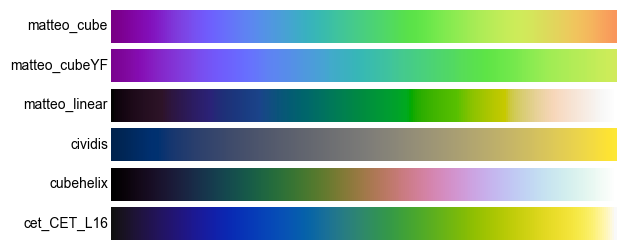

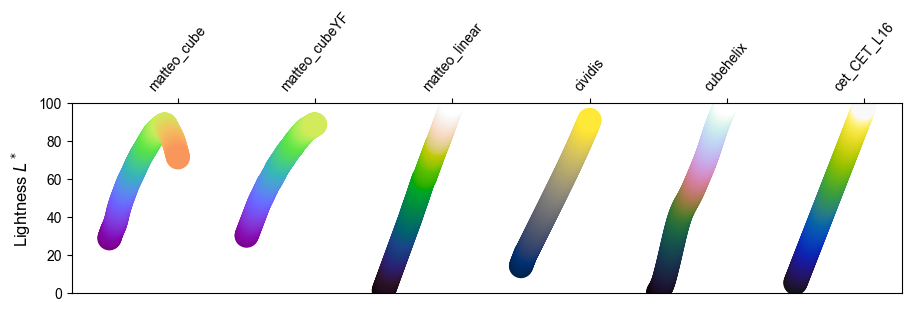

In [4]:
seqnt = ['matteo_cube', 'matteo_cubeYF', 'matteo_linear', 'cividis', 'cubehelix', 'cet_CET_L16']

plot_cmaps(seqnt)
plot_cmap_lightness(seqnt)

## sequential white to black colormaps (good for structural interpretation of seismic data)

I have collected here the "white sto blacks" and not the opposite because when used for seismic data the convention is to have the black mapped to the positive amplitudes (resembling the old convention of wiggle displays where the peak is filled in black and the trough is white).

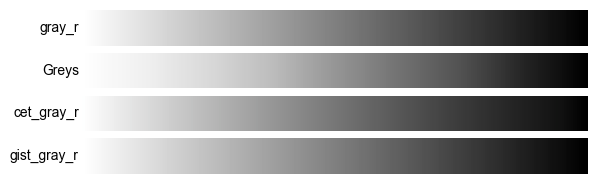

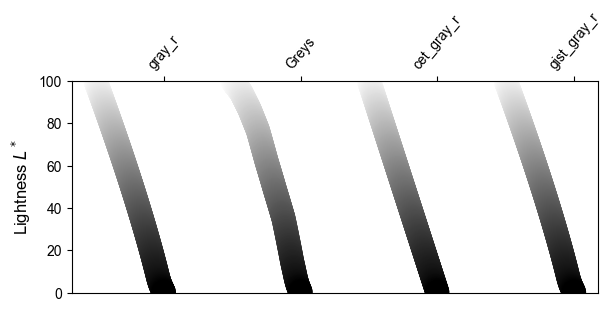

In [5]:
monos = ['gray_r',  'Greys', 'cet_gray_r', 'gist_gray_r']

plot_cmaps(monos)
plot_cmap_lightness(monos)

## sequential colormaps for topography and relief

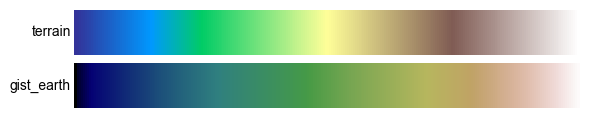

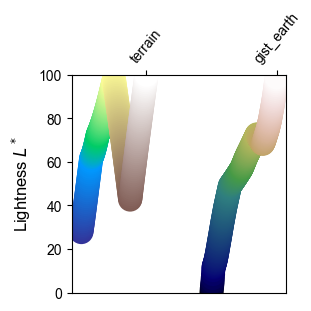

In [6]:
topog = ['terrain', 'gist_earth']

plot_cmaps(topog)
plot_cmap_lightness(topog)

## divergent colormaps (good for seismic amplitudes)

The first list (`seism0`) collects colormaps available in Matplotlib; the second list (`seism1`) shows the new colormaps that I have introduced and defined earlier:

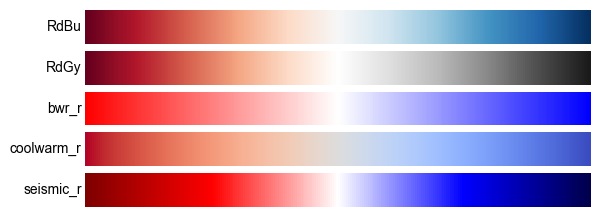

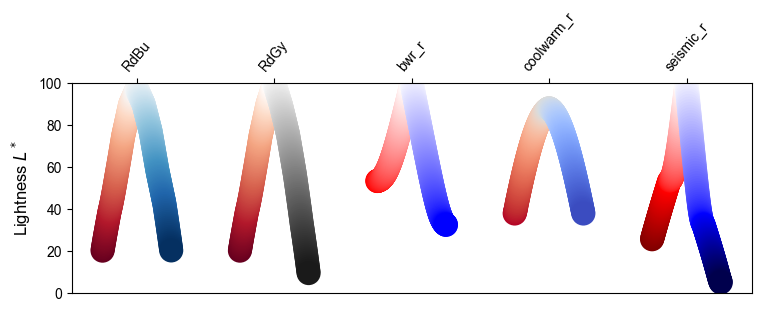

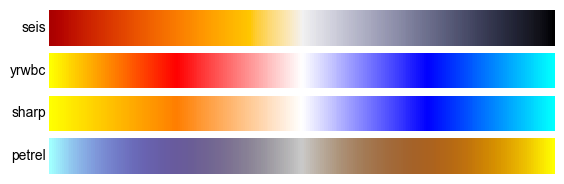

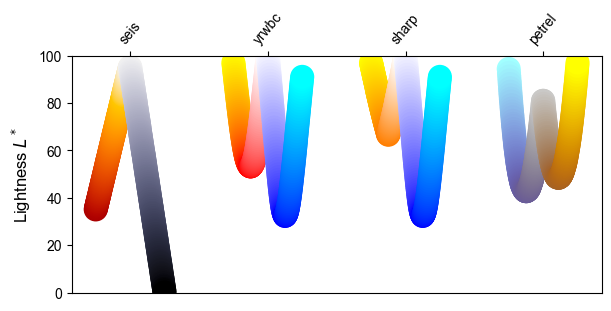

In [7]:
seism0 = ['RdBu', 'RdGy', 'bwr_r', 'coolwarm_r', 'seismic_r']

seism1 = ['seis', 'yrwbc', 'sharp', 'petrel']

plot_cmaps(seism0)
plot_cmap_lightness(seism0, divergent=True)

plot_cmaps(seism1)
plot_cmap_lightness(seism1, divergent=True)

## the rainbows!

Gotta be careful with those. I have come to the conclusion that for the time being, I will use `rainbowcet` (which is the same as Colorcet's `rainbow`, aka `cc.rainbow_bgyr_35_85_c73` or `'cet_rainbow_bgyr_35_85_c73'`).

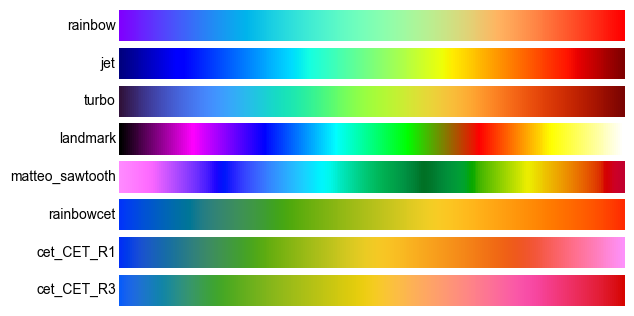

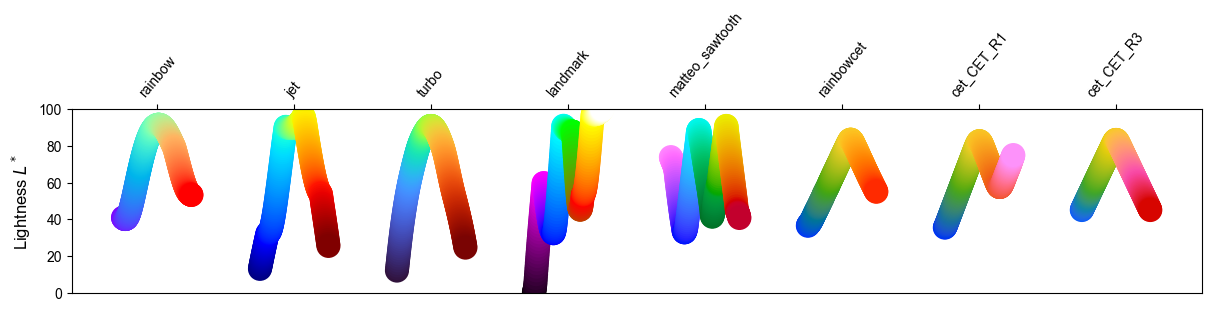

In [8]:
rainbs = ['rainbow', 'jet', 'turbo', 'landmark', 'matteo_sawtooth', 'rainbowcet', 'cet_CET_R1', 'cet_CET_R3']

plot_cmaps(rainbs)
plot_cmap_lightness(rainbs, divergent=True)

## the effect of colormaps on synthetic models

The problem with displaying colormaps in this way is that you don't get a feel for how they would really work, their subtleties etc. Showing the effects of these colormaps on simple 2D models brings the message home more effectively.

First I define two simple models:

* `A`: mountain and valley
* `B`: the fold

In [9]:
A, B = make_cmap_model()

Then I plot each of the model with a different colormap (top subplot), and extract a profile along the vertical axis filling it with the color based on the chosen colormap (bottom subplot).

Credit for the idea goes to Matteo Niccoli, see [here for details](https://mycarta.wordpress.com/2014/11/12/visualizing-colormap-artifacts/).

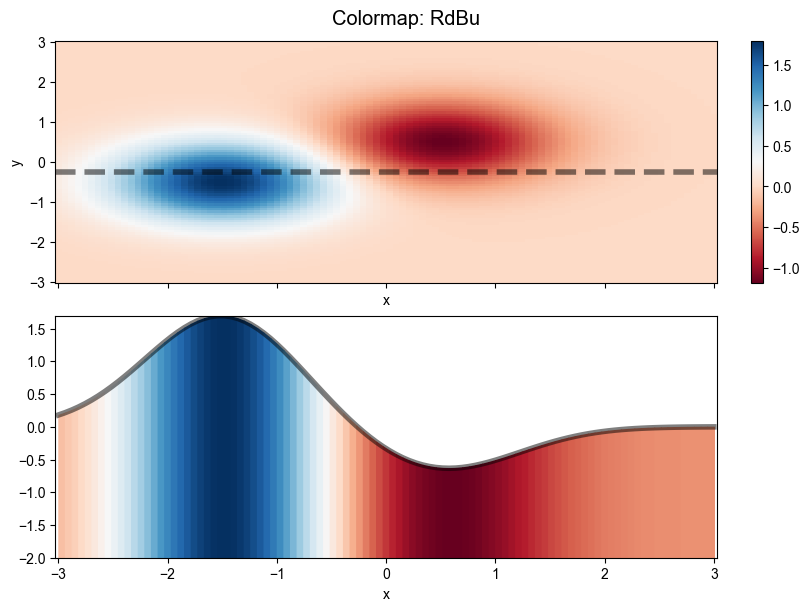

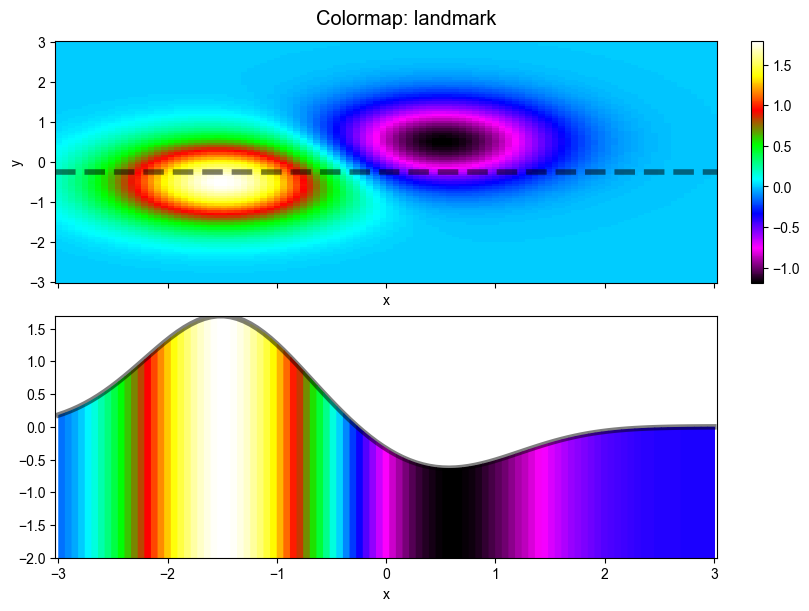

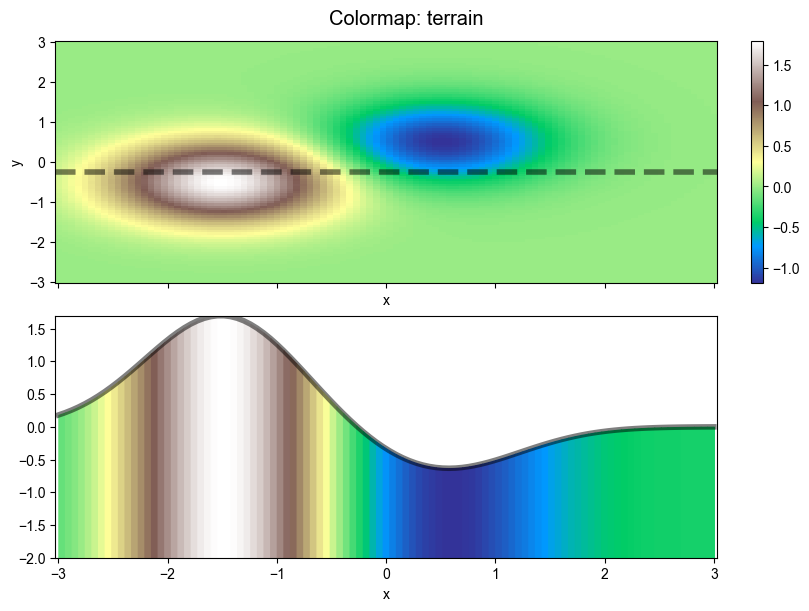

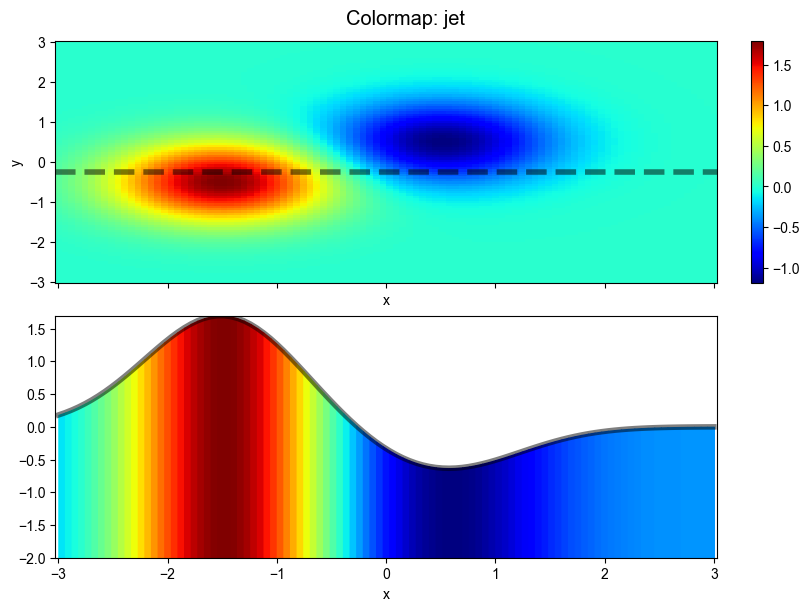

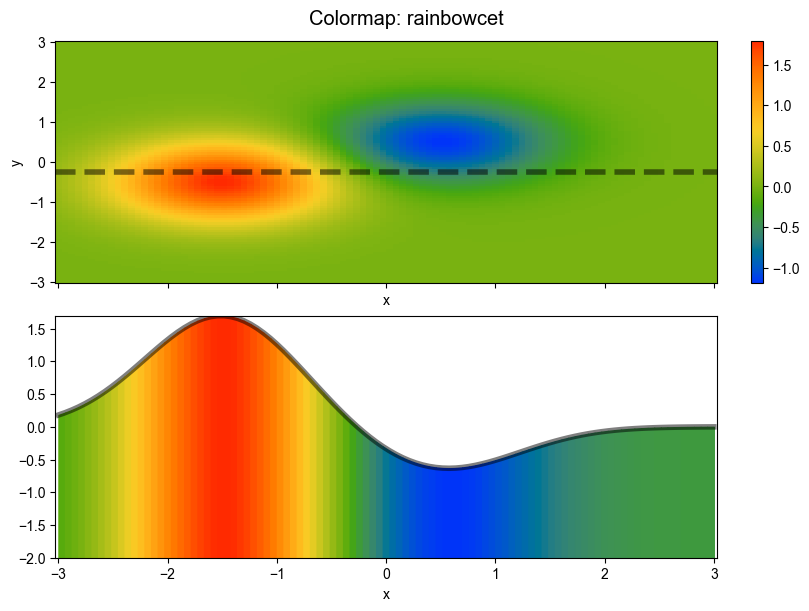

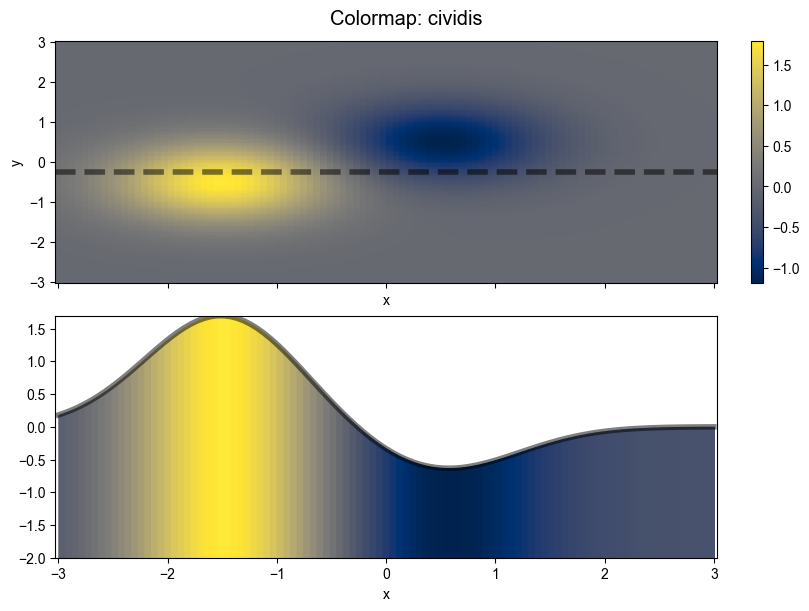

In [10]:
cmap_list = ['RdBu', 'landmark', 'terrain', 'jet', 'rainbowcet', 'cividis']
for cmap in cmap_list:
    plot_cmap_model(A, -.25, -2, cmap=cmap)

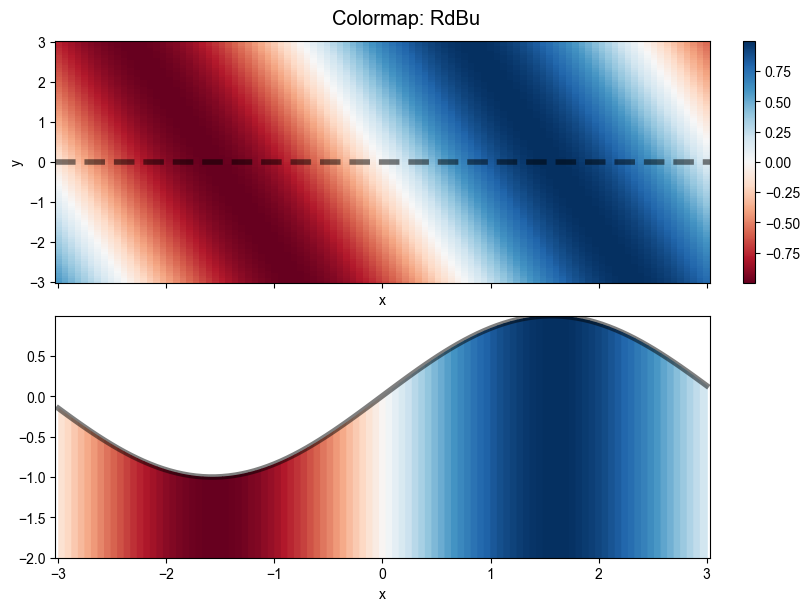

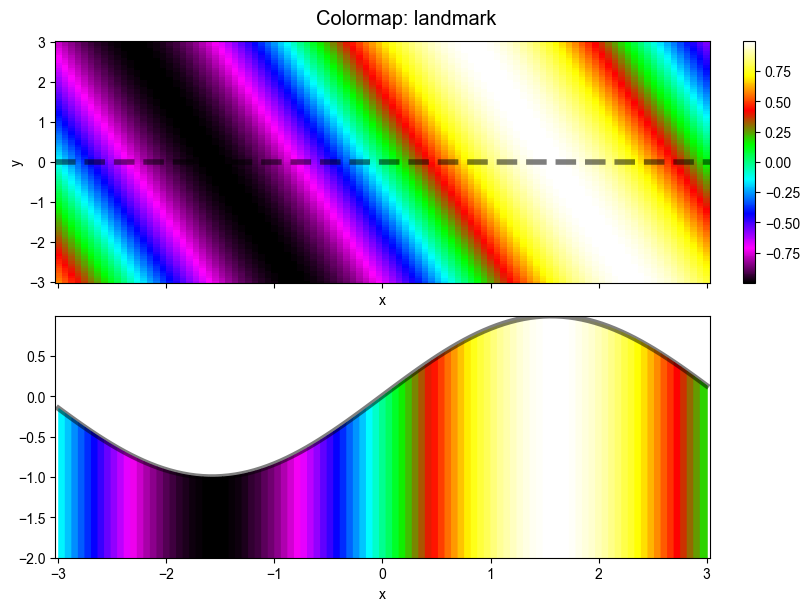

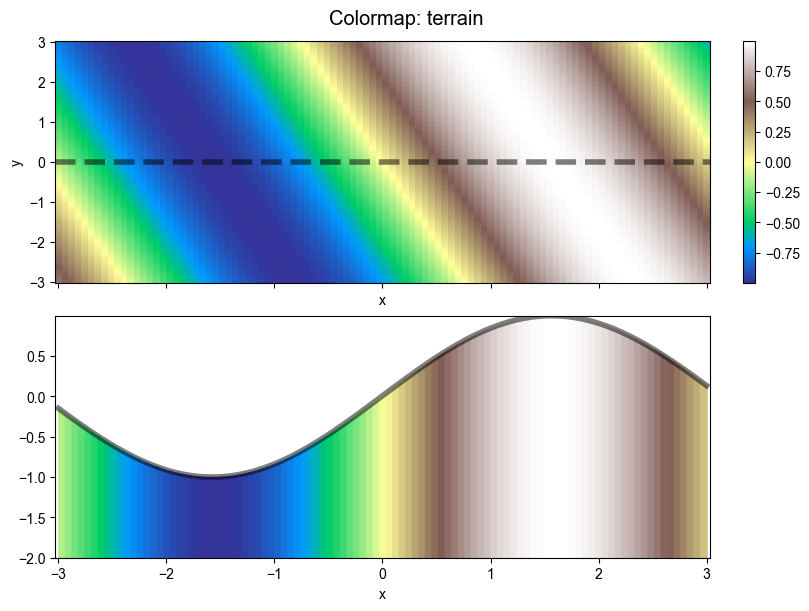

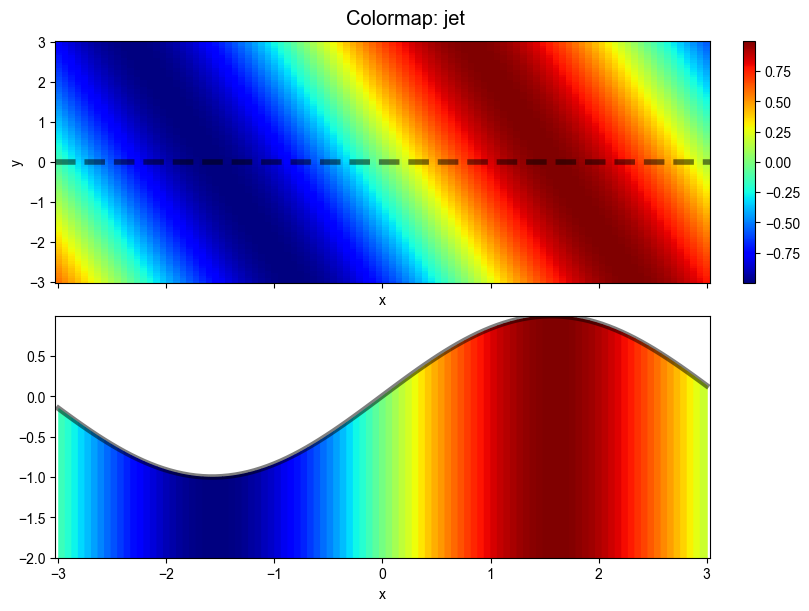

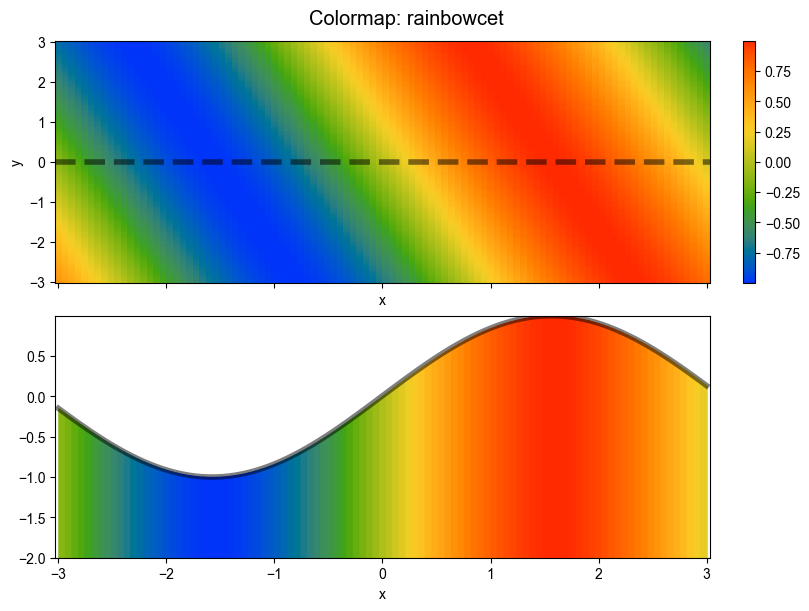

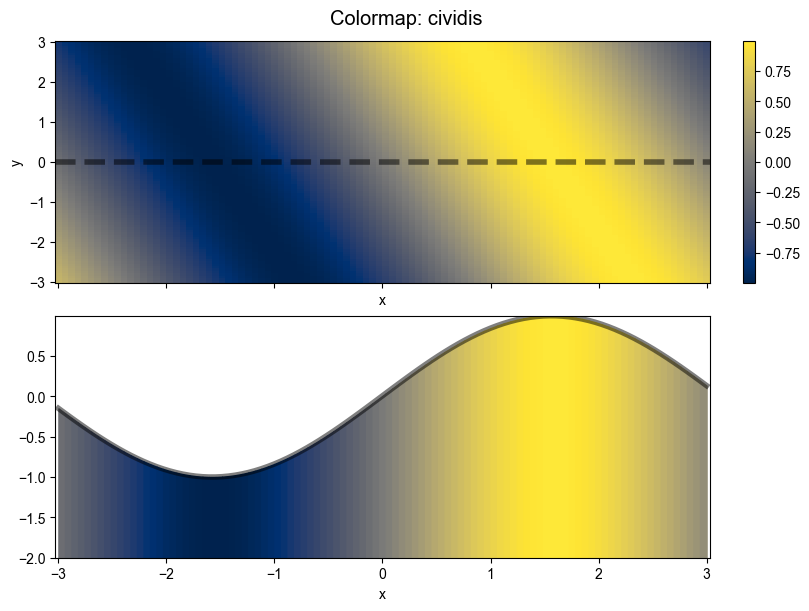

In [11]:
cmap_list = ['RdBu', 'landmark', 'terrain', 'jet', 'rainbowcet', 'cividis']
for cmap in cmap_list:
    plot_cmap_model(B, 0, -2, cmap=cmap)

## the effect of colormaps on real topography

Let's have a look at how these maps behave on real data. This is the [topography](https://www.ngdc.noaa.gov/mgg/global/global.html) from the North-West corner of Italy. As before, the top plot shows the terrain and the dashed line marks the selected profile that is reproduced in the bottom plot. This profile passes right across the Mont Blanc massif and goes down to the flatlands -- a true rollercoaster!

I bet most people would prefer `terrain` or `gist_earth`, and to be fair, they do look good. But just think at the artifacts that are introduced and leave `terrain` to Google Earth, please.

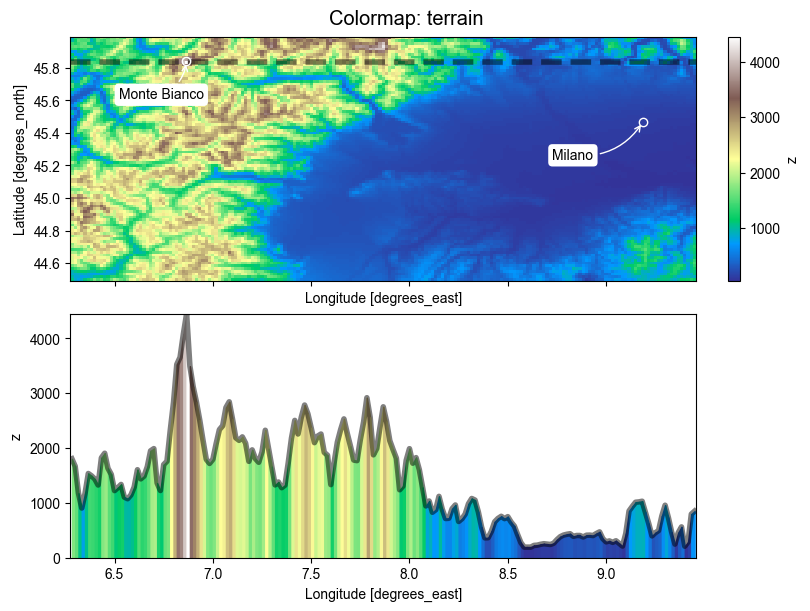

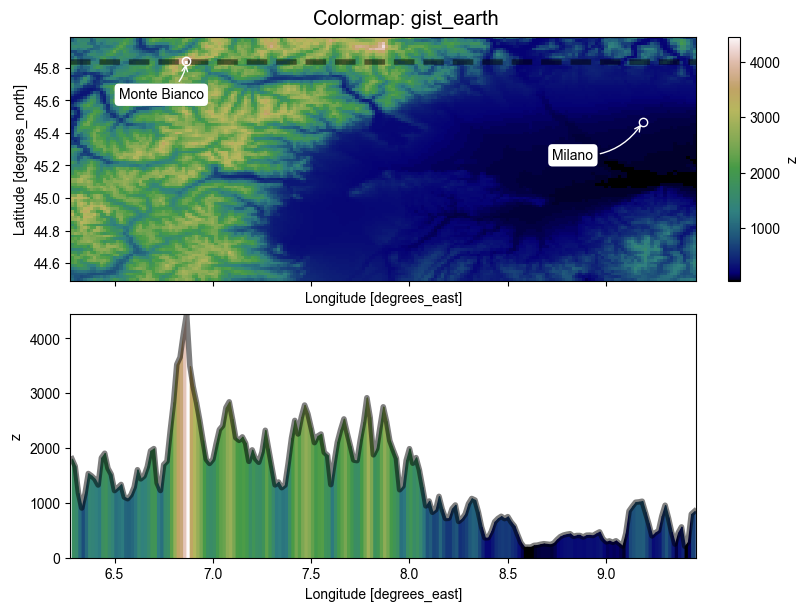

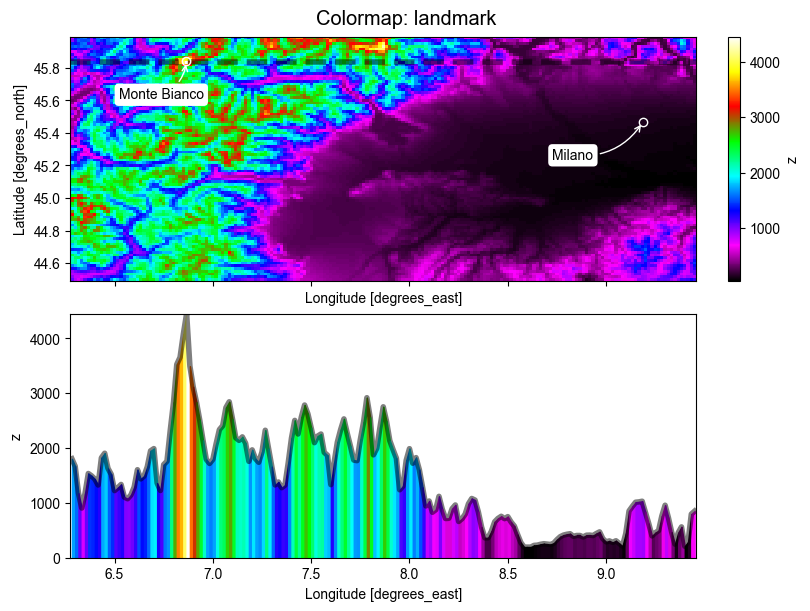

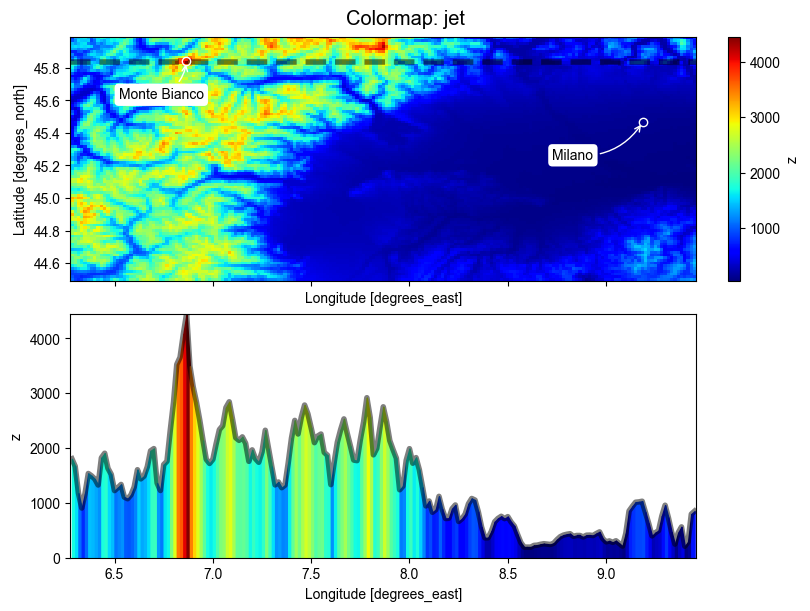

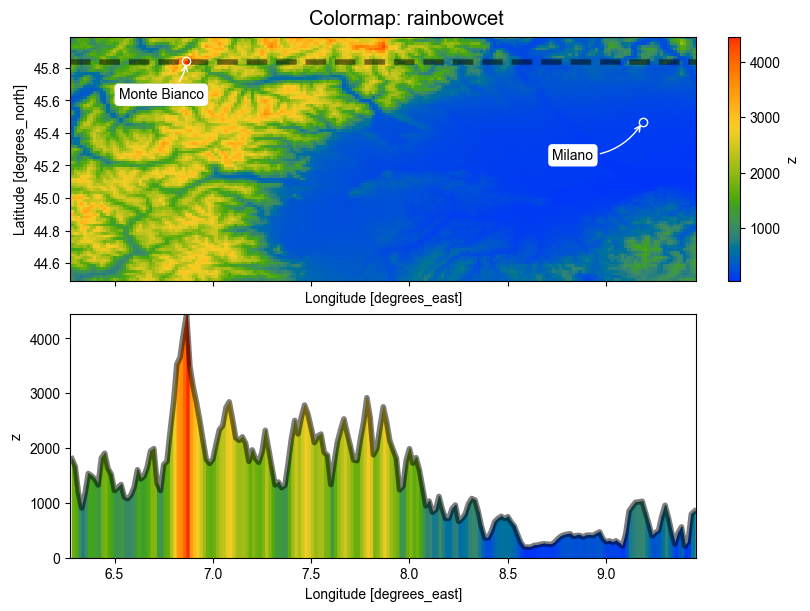

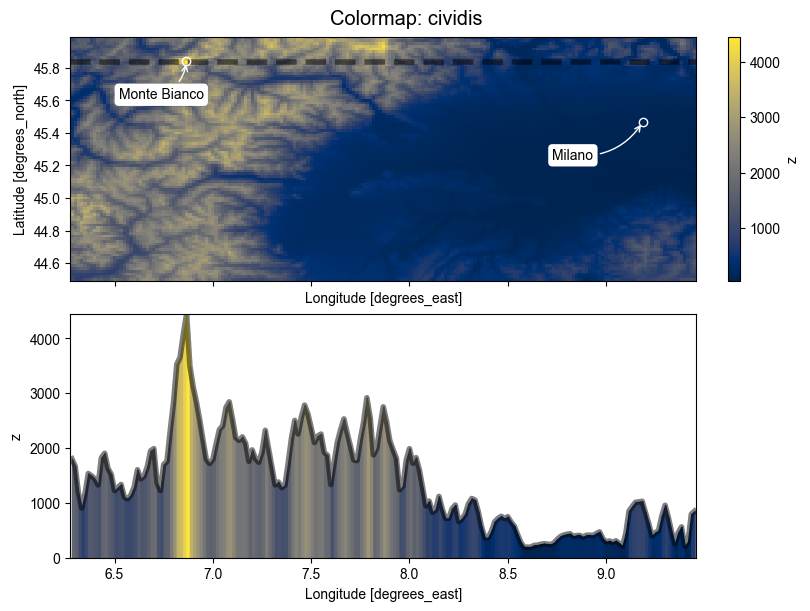

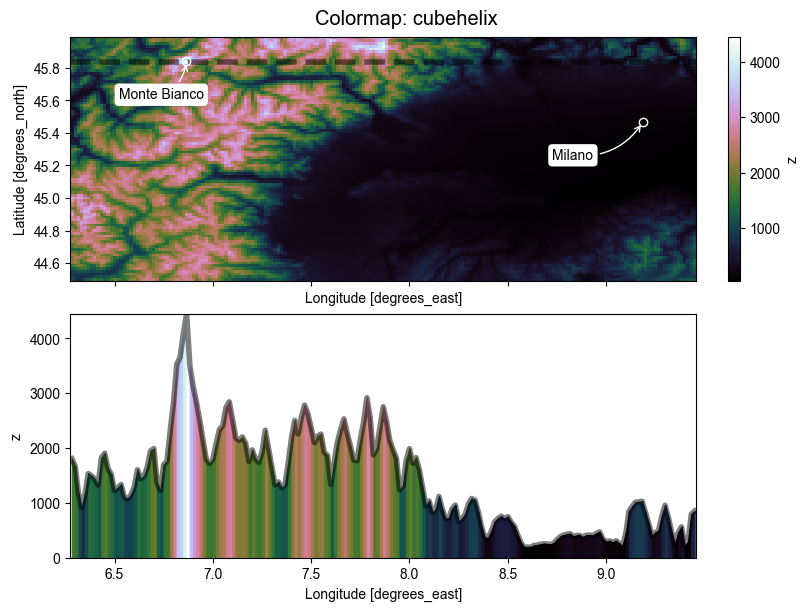

In [12]:
remote_file = 'https://github.com/aadm/geophysical_notes/raw/master/ETOPO1_it-nw.nc'
response = requests.get(remote_file)
itno = xr.open_dataset(io.BytesIO(response.content))

landmarks = np.array([
    [45.46504890183975, 9.186162057345419],  # milano
    [45.83912925921118, 6.864979544529871]]) # mont blanc
landmarks_name = ['Milano', 'Monte Bianco']


cmap_topo_list = ['terrain', 'gist_earth', 'landmark', 'jet', 'rainbowcet', 'cividis', 'cubehelix']

for cmap in cmap_topo_list:
    ax = plot_cmap_topo(itno, 45.839, 0, cmap=cmap)
    add_landmarks(ax[0], landmarks, landmarks_name)